Packages

In [ ]:
import os
import datetime

import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (15, 4)

In [ ]:
# !wget https://www.dropbox.com/s/6xc4a4ppcb6jjnj/itanagar.csv
# !wget https://www.dropbox.com/s/ptnez16ml2bpam0/guwahati.csv
# !wget https://www.dropbox.com/s/97xn7sek4uy2hfs/agartala.csv
# !wget https://www.dropbox.com/s/cq3cd6gahma41df/imphal.csv

In [ ]:
location = "itanagar"

params = {
    "lr": 0.01, # 0.0001 , 0.001 , 0.01
    "optimizer": "adamW", # Adafactor, adam, adamW, adadelta, adagrad, Adamax, Ftrl, Nadam, rmsprop, SGD
    "input_window" : 14,
    "output_window" : 1,
    "hidden_units" : 64,
    "epochs" : 20,
    "reduce_lr_monitor" : "val_mean_absolute_error", # val_mean_absolute_error, val_mean_squared_error
    "loss_fn" : "mean_absolute_error", # mean_absolute_error, mean_squared_error
}

In [ ]:
df = pd.read_csv(f"{location}.csv")
df["Date"] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.sort_values(by='Date').reset_index(drop = True)

abnormal_index = df[df["tMin"] > 60].index
for i in abnormal_index:
    df.loc[i, ["tMin"]] = df.loc[i-1]["tMin"].item()
    df.loc[i, ["tMax"]] = df.loc[i-1]["tMax"].item()

df.drop(["tMin", "tMax"], inplace = True, axis=1)

df

,Date,Rain
0,1951-01-01,0.0
1,1951-01-02,0.0
2,1951-01-03,0.0
3,1951-01-04,0.0
4,1951-01-05,0.0
...,...,...
25928,2021-12-27,0.0
25929,2021-12-28,0.0
25930,2021-12-29,0.0
25931,2021-12-30,0.0


In [ ]:
df = df.set_index('Date')
df = df.resample('M').mean()
df.head()

,Rain
Date,
1951-01-31,0.117026
1951-02-28,0.079307
1951-03-31,1.842452
1951-04-30,7.749113
1951-05-31,7.305297


In [ ]:
date_time = df.index

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_time, y=df["Rain"]))
fig.update_layout(xaxis_title="Date", yaxis_title="Rain")
fig.show()

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
# val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]
print(train_df.shape), print(test_df.shape), print(num_features)

(681, 1)
(171, 1)
1


(None, None, None)

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, test_df=test_df, # val_df=val_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    # self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data, shuff=True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=shuff,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  def plot(self, model=None, plot_col='Rain', max_subplots=3):
      inputs, labels = self.example
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
          fig = go.Figure()
          fig.add_trace(go.Scatter(x=self.input_indices, y=inputs[n, :, plot_col_index], mode='lines+markers', name='Inputs'))
          if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
          else:
              label_col_index = plot_col_index

          if label_col_index is None:
              continue

          fig.add_trace(go.Scatter(x=self.label_indices, y=labels[n, :, label_col_index], mode='lines+markers', name='Labels', marker=dict(color='#2ca02c', symbol='circle')))
          if model is not None:
              predictions = model(inputs)
              fig.add_trace(go.Scatter(x=self.label_indices, y=predictions[n, :, label_col_index], mode='lines+markers', name='Predictions', marker=dict(color='#ff7f0e', symbol='x')))
          if n == 0:
              fig.update_layout(showlegend=True)
          fig.update_layout(xaxis_title='Time [h]',yaxis_title=f'{plot_col} [normed]')
          fig.show()

  @property
  def train(self):
    return self.make_dataset(self.train_df)

#   def val(self):
#     return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df, shuff=False)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

In [ ]:
IN_STEPS = params["input_window"]
OUT_STEPS = params["output_window"]

window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['Rain']) #

print(window)
# window.plot( plot_col='Rain', max_subplots=3)

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['Rain']


In [ ]:
print('Input shape:', window.example[0].shape)
print('Input label shape:', window.example[1].shape)

Input shape: (32, 14, 1)
Input label shape: (32, 1, 1)


# Model

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(params["hidden_units"], return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(OUT_STEPS*1,kernel_initializer=tf.initializers.zeros()))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))



MAX_EPOCHS = params["epochs"]

patience = 4

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= params["reduce_lr_monitor"], factor=0.05, patience=int(patience/2), min_delta=0.01)
clb = [ reduce_lr] # early_stopping,

if params["optimizer"] == 'Adafactor':
    opt = tf.keras.optimizers.experimental.Adafactor(lr = params["lr"])
elif params["optimizer"] == "adam":
    opt = tf.keras.optimizers.Adam(lr = params["lr"])
elif params["optimizer"] == "adamW":
    opt = tf.keras.optimizers.experimental.AdamW(lr = params["lr"])
elif params["optimizer"] == "adadelta":
    opt = tf.keras.optimizers.experimental.Adadelta(lr = params["lr"])
elif params["optimizer"] == "adagrad":
    opt = tf.keras.optimizers.experimental.Adagrad(lr = params["lr"])
elif params["optimizer"] == "Adamax":
    opt = tf.keras.optimizers.experimental.Adamax(lr = params["lr"])
elif params["optimizer"] == "Ftrl":
    opt = tf.keras.optimizers.experimental.Ftrl(lr = params["lr"])
elif params["optimizer"] == "Nadam":
    opt = tf.keras.optimizers.experimental.Nadam(lr = params["lr"])
elif params["optimizer"] == "rmsprop":
    opt = tf.keras.optimizers.experimental.RMSprop(lr = params["lr"])
elif params["optimizer"] == "SGD":
    opt = tf.keras.optimizers.experimental.SGD(lr = params["lr"])

model.compile(loss= params["loss_fn"],
            optimizer = opt,
            metrics=[
                tf.keras.metrics.MeanAbsoluteError(),
                # tf.keras.metrics.MeanSquaredError(),
                # tf.keras.metrics.MeanAbsolutePercentageError(),
                tf.keras.metrics.RootMeanSquaredError()
            ])

In [ ]:


history = model.fit(window.train, epochs=MAX_EPOCHS,
                    validation_data=window.test,
                    callbacks= clb )

Epoch 1/20
21/21 [==============================] - 6s 67ms/step - loss: 0.8486 - mean_absolute_error: 0.8486 - root_mean_squared_error: 0.9964 - val_loss: 0.7811 - val_mean_absolute_error: 0.7811 - val_root_mean_squared_error: 0.8952 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - 1s 20ms/step - loss: 0.7670 - mean_absolute_error: 0.7670 - root_mean_squared_error: 0.9253 - val_loss: 0.5797 - val_mean_absolute_error: 0.5797 - val_root_mean_squared_error: 0.7084 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - 0s 20ms/step - loss: 0.5026 - mean_absolute_error: 0.5026 - root_mean_squared_error: 0.7058 - val_loss: 0.3967 - val_mean_absolute_error: 0.3967 - val_root_mean_squared_error: 0.5465 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - 1s 23ms/step - loss: 0.3999 - mean_absolute_error: 0.3999 - root_mean_squared_error: 0.5753 - val_loss: 0.3689 - val_mean_absolute_error: 0.3689 - val_root_mean_squared_error: 0.5375 - lr: 0.0010
Epoch 5/

In [ ]:
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 65        
                                                                 
 reshape_46 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_info = pd.DataFrame(history.history)
fit_info.columns

Index(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss',
       'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'],
      dtype='object')

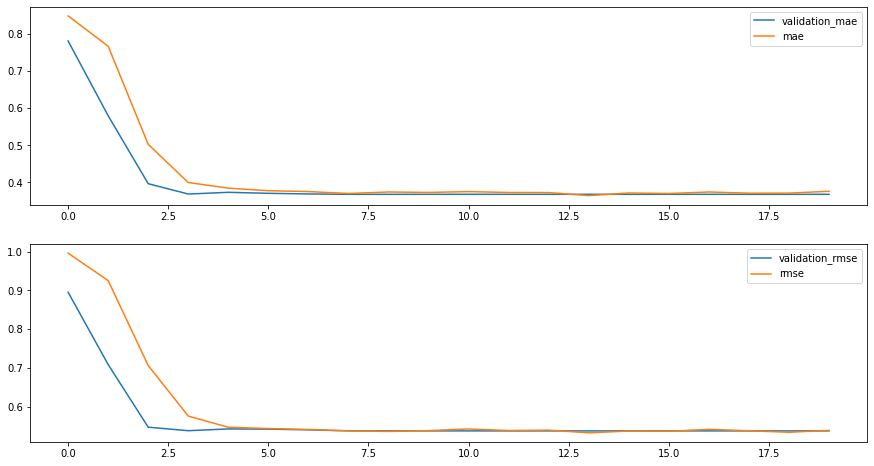

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
# ax[0].plot(fit_info[["mean_absolute_percentage_error"]], label="mape")
# ax[0].plot(fit_info[["val_mean_absolute_percentage_error"]], label="v_mape")
# ax[0].legend()
ax[0].plot(fit_info[["val_mean_absolute_error"]], label="validation_mae")
ax[0].plot(fit_info[["mean_absolute_error"]], label="mae")
ax[0].legend()
ax[1].plot(fit_info[["val_root_mean_squared_error"]], label='validation_rmse')
ax[1].plot(fit_info[["root_mean_squared_error"]], label='rmse')
ax[1].legend()


In [ ]:
test_performance = model.evaluate(window.test, verbose=0)

print("Test metrics")
for j, metric in enumerate(test_performance):
    print(f"eval/{model.metrics_names[j]} = {metric}")

Test metrics
eval/loss = 0.36807534098625183
eval/mean_absolute_error = 0.36807534098625183
eval/root_mean_squared_error = 0.5369858741760254


In [ ]:
# window.plot(model)

In [ ]:
print('Output shape (batch, time, features): ', model(window.example[0]).shape)

Output shape (batch, time, features):  (32, 1, 1)


In [ ]:
test_data = window.test

inputs_all = np.zeros((1, IN_STEPS, window.example[0].shape[-1]))
labels_all = np.zeros((1, OUT_STEPS, window.example[1].shape[-1]))
preds_all = np.zeros((1, OUT_STEPS, model(window.example[0]).shape[-1]))

i = 0
for data, label in test_data:
    inputs_all = np.append(inputs_all, data, axis=0)
    labels_all = np.append(labels_all, label, axis=0)
    preds_all = np.append(preds_all, model(data), axis=0)

inputs_all = inputs_all[1:, :, :]
labels_all = labels_all[1:, :, :]
preds_all = preds_all[1:, :, :]

inputs_all.shape, labels_all.shape, preds_all.shape

((157, 14, 1), (157, 1, 1), (157, 1, 1))

In [ ]:
test_df_all = window.test_df.copy(deep=True)
test_df_all["Date"] = test_df_all.index
test_df_all.reset_index(inplace=True, drop=True)

for i in range(OUT_STEPS):
    test_df_all[f"l{i}"] = np.nan
    test_df_all[f"p{i}"] = np.nan

    test_df_all[f'l{i}'].loc[IN_STEPS+i: IN_STEPS+len(labels_all)-1+i] = labels_all[:, i, 0]
    test_df_all[f'p{i}'].loc[IN_STEPS+i: IN_STEPS+len(preds_all)-1+i] = preds_all[:, i, 0]

test_df_all.head()

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Rain,Date,l0,p0
0,-0.604905,2007-10-31,NaN,NaN
1,-0.955921,2007-11-30,NaN,NaN
2,-0.948812,2007-12-31,NaN,NaN
3,-0.865094,2008-01-31,NaN,NaN
4,-0.906548,2008-02-29,NaN,NaN


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_df_all["Date"], y=test_df_all["Rain"], name="Truth"))
for i in range(OUT_STEPS):
    fig.add_trace(go.Scatter(x=test_df_all["Date"], y=test_df_all[f"p{i}"], name=f"day{i+1}"))

fig.update_layout(showlegend=True,xaxis_title='Date',yaxis_title='Normalized Rain')
fig.show()

In [ ]:

test_df_all["Rain"] = test_df_all["Rain"]*train_std[0] + train_mean[0]

for i in range(OUT_STEPS):
    test_df_all[f'l{i}'] = test_df_all[f'l{i}']*train_std[0] + train_mean[0]
    test_df_all[f'p{i}'] = test_df_all[f'p{i}']*train_std[0] + train_mean[0]


fig = go.Figure()

fig.add_trace(go.Scatter(x=test_df_all["Date"], y=test_df_all["Rain"], name="Truth"))
for i in range(OUT_STEPS):
    fig.add_trace(go.Scatter(x=test_df_all["Date"], y=test_df_all[f"p{i}"], name=f"day{i+1}"))

fig.update_layout(showlegend=True,xaxis_title='Date',yaxis_title='Rain', title=location)
fig.show()

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# cm = confusion_matrix(test_df_all["Rain"] > 0, test_df_all["p0"]>0)
# cm_df = pd.DataFrame(cm,
#                      index = ['Rain','No Rain'],
#                      columns =['Rain','No Rain'])

# #Plotting the confusion matrix
# plt.figure(figsize=(8,5))
# sns.heatmap(cm_df, annot=True,  fmt='g')
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

In [ ]:
# labels = [0,1,2]

# true_bins = [test_df_all["Rain"].min(), test_df_all["Rain"].mean(), test_df_all["Rain"].mean() + 2*test_df_all["Rain"].std(), test_df_all["Rain"].max() ]
# # print(true_bins)
# y_true_cat = pd.cut(x = test_df_all["Rain"], bins =  true_bins, labels = labels, include_lowest=True)

# pred_bins = [test_df_all["p0"].min(), test_df_all["p0"].mean(), test_df_all["p0"].mean() + 2*test_df_all["p0"].std(), test_df_all["p0"].max() ]
# # print(pred_bins)
# y_pred_cat = pd.cut(x = test_df_all["p0"], bins =  pred_bins, labels = labels, include_lowest=True).fillna(0)

# cm = confusion_matrix(y_true_cat, y_pred_cat)
# cm_df = pd.DataFrame(cm,
#                      index = ['Low Rain','Medium Rain','Heavy Rain'],
#                      columns = ['Low Rain','Medium Rain','Heavy Rain'])

# #Plotting the confusion matrix
# plt.figure(figsize=(8,5))
# sns.heatmap(cm_df, annot=True,  fmt='g')
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()